# Runtime  Prediction via QC

## About

This notebook is designed to 1) create a dataframe that brings together runtime information with the [information](https://docs.google.com/spreadsheets/d/1zSs_hRQrCIBlUmPpDvyEwpJv3X4t8Y73s6ZRdkBkeI8/edit#gid=983410225) provided by the QC group.  It then 2) calculates the correlation of QC variables to runtime for a core variant calling workflows.  Based on those correlations, it 3) generates a linear regression model to predict runtime from QC variables and then 4) evaluates the performance of this model on ~20% of the dataset that was excluded from the training.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

In [2]:
import math
# read a dict for runtimes
f = open("dkfz_embl_timing.tsv", "r")
runtimes = {}
for line in iter(f):
    a = line.split("\t")
    runtimes[a[0]] = a[1]
f.close()

# read data into a DataFrame
data = pd.read_csv('PCAWG-QC_Summary-of-Measures_QC_Measures.tsv', delimiter='\t')
data['runtime'] = 0.0
# loop over and annotate with runtime
for index, row in data.iterrows():
    key = row['Project_code'] + "::" + row['Submitter_donor_ID']
    try:
        curr_runtime = math.log(float(runtimes[key]))
        #curr_runtime = float(runtimes[key])
        data.set_value(index, 'runtime', curr_runtime)
    except:
        continue
        
data.head()

,Project_code,Submitter_donor_ID,Normal_WGS_aliquot_ID,Tumour_WGS_aliquot_ID,Stars,Mean_Coverage_Normal,Mean_Coverage_Tumour,Median/Mean_Coverage_Normal,FWHM_Normal,Median/Mean_Coverage_Tumour,FWHM_Tumour,Somatic_Mutation_Calling_Coverage,%_of_paired_reads_mapping_to_different_chromosomes_Normal,%_of_paired_reads_mapping_to_different_chromosomes_Tumour,Ratio_of_difference_in_edits_between_paired_reads_Normal,Ratio_of_difference_in_edits_between_paired_reads_Tumour,runtime
0,BLCA-US,096b4f32-10c1-4737-a0dd-cae04c54ee33,e0fccaf5-925a-41f9-b87c-cd5ee4aecb59,301d6ce3-4099-4c1d-8e50-c04b7ce91450,5.0,37.98,45.40,1.026162,0.088868,1.038914,0.152645,2.802268e+09,2.14,2.32,1.177728,1.200458,0.0
1,BLCA-US,178b28cd-99c3-48dc-8d09-1ef71b4cee80,c1da8eed-4919-4ba5-a735-3fba476c18a7,4838b5a9-968c-4178-bffb-3fafe1f6dc09,5.0,31.50,33.65,1.015003,0.114352,0.981037,0.097032,2.746502e+09,2.41,1.80,1.219270,1.093826,0.0
2,BLCA-US,1e308b12-0590-4dae-94d0-a539fcf25df7,d6e91f4c-38c0-4393-9cb7-be076663dff3,c66c92d5-df65-46e6-861d-d8a98808e6a3,5.0,32.72,30.71,1.021017,0.095867,0.968090,0.085069,2.733112e+09,1.97,2.03,1.178552,1.159640,0.0
3,BLCA-US,24f21425-b001-4986-aedf-5b4dd851c6ad,f88b2f4c-15f1-4808-bcec-89abc7466de6,973d0577-8ca4-44a1-817f-1d3c1bada151,4.5,37.60,39.17,1.012372,0.093099,0.893826,0.070527,2.773264e+09,2.93,2.12,1.188315,1.198255,0.0
4,BLCA-US,3ed614e7-f356-4d87-985b-d3bbbae3bb40,c14e29aa-a979-4452-8019-7eebfb3d5d04,91f458e6-64b7-454d-a542-b0aa23638fd8,5.0,31.90,33.55,1.011833,0.083130,0.931186,0.081127,2.633835e+09,2.05,1.95,1.003750,1.063998,0.0


In [3]:
# now I have a merged dataframe that has all QC values along with the runtime for the workflow
print(data.shape)

(2961, 17)


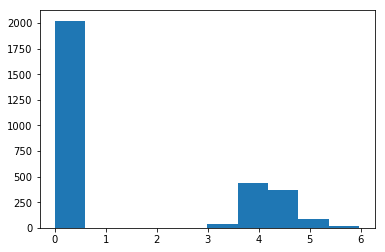

In [4]:
# Import matplotlib
import matplotlib.pyplot as plt

# Make a histogram of all the ratings in the average_rating column.
plt.hist(data["runtime"])

# Show the plot.
plt.show()

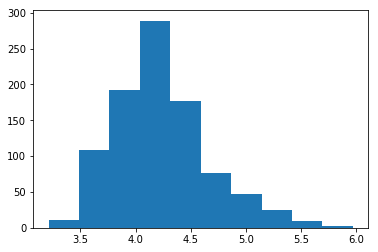

In [5]:
# remove 0 runtimes
data = data[data["runtime"] > 0.0]
plt.hist(data["runtime"])
plt.show()

In [6]:
# remove any NAN
data = data.dropna() 
data.isnull().values.any()

False

In [7]:
# showing zeros and nan have been removed
print(data.shape)

(937, 17)


In [8]:
# general stats
data.describe()

,Stars,Mean_Coverage_Normal,Mean_Coverage_Tumour,Median/Mean_Coverage_Normal,FWHM_Normal,Median/Mean_Coverage_Tumour,FWHM_Tumour,Somatic_Mutation_Calling_Coverage,%_of_paired_reads_mapping_to_different_chromosomes_Normal,%_of_paired_reads_mapping_to_different_chromosomes_Tumour,Ratio_of_difference_in_edits_between_paired_reads_Normal,Ratio_of_difference_in_edits_between_paired_reads_Tumour,runtime
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,9.370000e+02,937.000000,937.000000,937.000000,937.000000,937.000000
mean,4.586980,40.256222,49.875293,1.025553,0.108813,1.007339,0.118156,2.761259e+09,1.997556,2.130139,1.434132,1.413395,4.228970
std,0.675155,11.281431,16.080767,0.019546,0.052558,0.036155,0.064702,8.729496e+07,2.196375,2.022165,0.343361,0.330034,0.427763
min,1.000000,19.410000,24.480000,0.814913,0.046188,0.794605,0.046799,2.238913e+09,0.290000,0.360000,1.007771,1.001541,3.211112
25%,4.000000,32.850000,37.340000,1.016658,0.076872,0.991415,0.080804,2.731131e+09,0.970000,1.020000,1.229268,1.225925,3.922166
50%,5.000000,37.570000,45.970000,1.027080,0.094580,1.013954,0.100412,2.797672e+09,1.370000,1.420000,1.365726,1.347176,4.176769
75%,5.000000,44.770000,60.600000,1.034095,0.123442,1.029177,0.134247,2.817698e+09,2.090000,2.470000,1.565019,1.510329,4.450509
max,5.000000,137.620000,145.350000,1.106314,0.720957,1.121758,0.860889,2.845337e+09,29.910000,18.640000,4.740884,5.220612,5.971718


In [9]:
# look at correlation
data.corr()["runtime"]

Stars                                                       -0.054133
Mean_Coverage_Normal                                         0.539613
Mean_Coverage_Tumour                                         0.580469
Median/Mean_Coverage_Normal                                 -0.109907
FWHM_Normal                                                  0.098749
Median/Mean_Coverage_Tumour                                  0.013958
FWHM_Tumour                                                  0.155226
Somatic_Mutation_Calling_Coverage                            0.232398
%_of_paired_reads_mapping_to_different_chromosomes_Normal    0.080802
%_of_paired_reads_mapping_to_different_chromosomes_Tumour    0.159431
Ratio_of_difference_in_edits_between_paired_reads_Normal     0.021782
Ratio_of_difference_in_edits_between_paired_reads_Tumour     0.026488
runtime                                                      1.000000
Name: runtime, dtype: float64

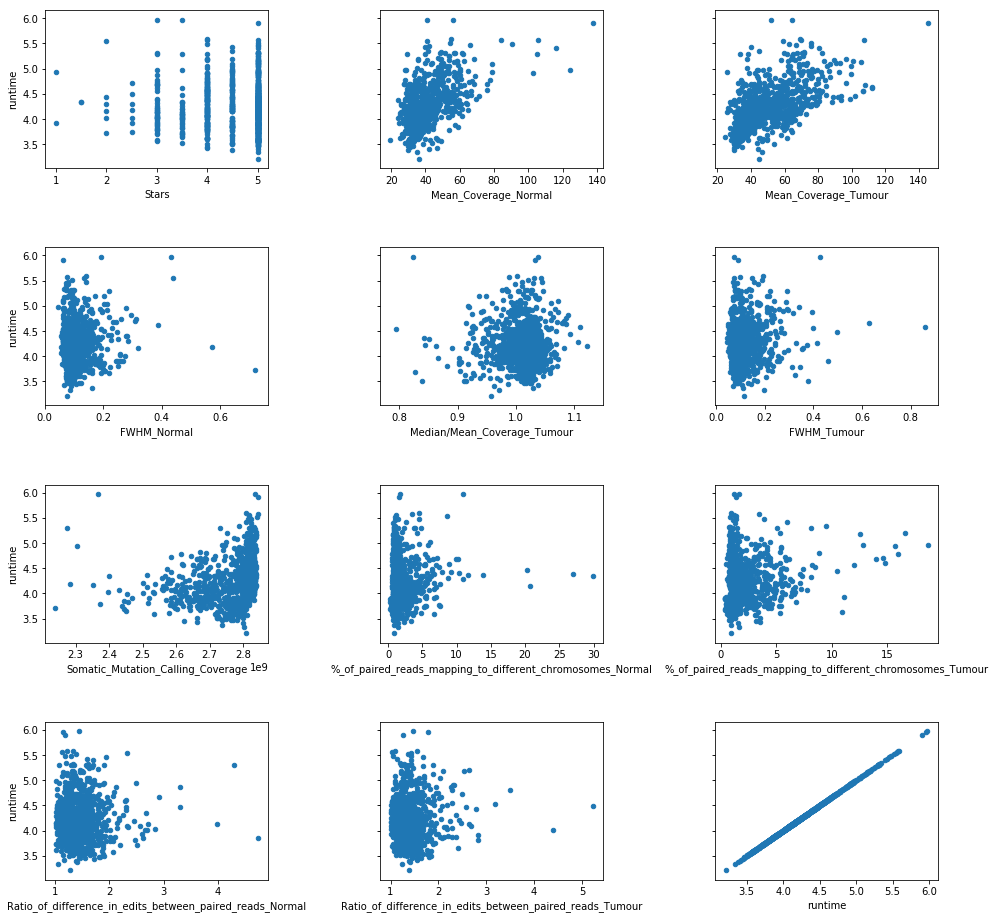

In [10]:
# visualize the relationship between the features and the response using scatterplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 3, sharey=True)
fig.subplots_adjust(hspace=.5, wspace=.5)
data.plot(kind='scatter', x='Stars', y='runtime', ax=axs[0, 0], figsize=(16, 16))
data.plot(kind='scatter', x='Mean_Coverage_Normal', y='runtime', ax=axs[0, 1])
data.plot(kind='scatter', x='Mean_Coverage_Tumour', y='runtime', ax=axs[0, 2])
data.plot(kind='scatter', x='FWHM_Normal', y='runtime', ax=axs[1, 0])
data.plot(kind='scatter', x='Median/Mean_Coverage_Tumour', y='runtime', ax=axs[1, 1])
data.plot(kind='scatter', x='FWHM_Tumour', y='runtime', ax=axs[1, 2])
data.plot(kind='scatter', x='Somatic_Mutation_Calling_Coverage', y='runtime', ax=axs[2, 0])
data.plot(kind='scatter', x='%_of_paired_reads_mapping_to_different_chromosomes_Normal', y='runtime', ax=axs[2, 1])
data.plot(kind='scatter', x='%_of_paired_reads_mapping_to_different_chromosomes_Tumour', y='runtime', ax=axs[2, 2])
data.plot(kind='scatter', x='Ratio_of_difference_in_edits_between_paired_reads_Normal', y='runtime', ax=axs[3, 0])
data.plot(kind='scatter', x='Ratio_of_difference_in_edits_between_paired_reads_Tumour', y='runtime', ax=axs[3, 1])
data.plot(kind='scatter', x='runtime', y='runtime', ax=axs[3, 2])


In [11]:
# now clear out the columns that we don't want to use
# Get all the columns from the dataframe.
columns = data.columns.tolist()
# Filter the columns to remove ones we don't want.
columns = [c for c in columns if c not in ["runtime", "Project_code", "Submitter_donor_ID", "Normal_WGS_aliquot_ID", "Tumour_WGS_aliquot_ID"]]
#columns = [c for c in columns if c not in ["runtime", "Project_code", "Submitter_donor_ID", "Normal_WGS_aliquot_ID", "Tumour_WGS_aliquot_ID", "Median/Mean_Coverage_Normal", "FWHM_Normal", "Median/Mean_Coverage_Tumour", "FWHM_Tumour", "Somatic_Mutation_Calling_Coverage", "%_of_paired_reads_mapping_to_different_chromosomes_Normal", "Ratio_of_difference_in_edits_between_paired_reads_Normal", "Ratio_of_difference_in_edits_between_paired_reads_Tumour"]]

# Store the variable we'll be predicting on.
target = "runtime"

In [12]:
# Import a convenience function to split the sets.
from sklearn.model_selection import train_test_split

# Generate the training set.  Set random_state to be able to replicate results.
train = data.sample(frac=0.8, random_state=1)
# Select anything not in the training set and put it in the testing set.
test = data.loc[~data.index.isin(train.index)]
# Print the shapes of both sets.
print(train.shape)
print(test.shape)

(750, 17)
(187, 17)


In [13]:
# Import the linearregression model.
from sklearn.linear_model import LinearRegression

# Initialize the model class.
model = LinearRegression()
train.head()
# Fit the model to the training data.
model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
# now test 
# Import the scikit-learn function to compute error.
from sklearn.metrics import mean_squared_error

# Generate our predictions for the test set.
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values.
mean_squared_error(predictions, test[target])

0.082015924085512878

In [15]:
# try random forest
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with some parameters.
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=1)
# Fit the model to the data.
model.fit(train[columns], train[target])
# Make predictions.
predictions = model.predict(test[columns])
# Compute the error.
mean_squared_error(predictions, test[target])

0.062229931635604328

                            OLS Regression Results                            
Dep. Variable:      predicted_runtime   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     2581.
Date:                Sun, 05 Feb 2017   Prob (F-statistic):          3.62e-271
Time:                        22:46:15   Log-Likelihood:                 331.63
No. Observations:                 937   AIC:                            -659.3
Df Residuals:                     935   BIC:                            -649.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.4389      0.055     26.057      0.0

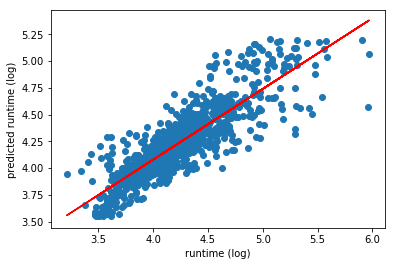

In [19]:
# look at predicted vs. actual
import statsmodels.api as sm
import numpy as np


data['predicted_runtime'] = model.predict(data[columns])
#data.plot(kind='scatter', x='runtime', y='predicted_runtime')

results = sm.OLS(data['predicted_runtime'],sm.add_constant(data['runtime'])).fit()

print(results.summary())

plt.scatter(data['runtime'],data['predicted_runtime'])

#X_plot = np.linspace(0,1,100)
#plt.plot(X_plot, X_plot*results.params[0] + results.params[1])

# fit with np.polyfit
m, b = np.polyfit(data['runtime'], data['predicted_runtime'], 1)

#plt.plot(x, y, '.')
plt.plot(data['runtime'], m*data['runtime'] + b, '-', color='r')
plt.ylabel('predicted runtime (log)')
plt.xlabel('runtime (log)')

plt.show()


## Summary
Seems like the coverage dominates the runtime.  The model agrees with actual runtime fairly well, R^2 of 0.734